# Space example
This is taken largely from ?Space with some info from Nicole's tutorial.
There is useful info here: https://figshare.com/articles/dataset/pub_shobe_etal_GMD/5193478
although lots of the code there is depreciated so it does not run as written.

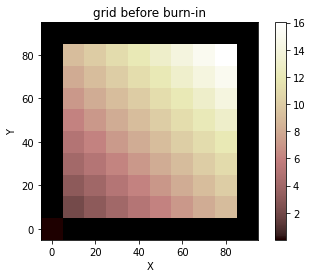

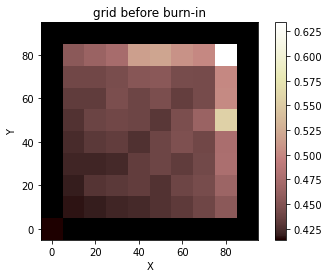

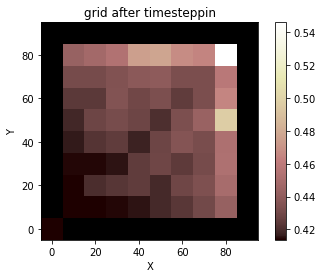

In [78]:
# this is from the space help
import numpy as np
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space)
from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline


# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

mg = RasterModelGrid((10, 10), xy_spacing=10.0)
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10. + 
                                         mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.)
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)
fsc_dt = 100.
space_dt = 100.

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()



#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for x in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.001 # Uplift
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()




# init the space component
ha = Space(
    mg,
    K_sed=0.00001,
    K_br=0.00000000001,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)

# run Space component for 2000 short timesteps:

for x in range(2000): #Space component loop
    fr.run_one_step()
    df.map_depressions()
    ha.run_one_step(dt=space_dt)
    mg.at_node['bedrock__elevation'][0] -= 2e-6 * space_dt
    
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()